In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Read data from csv files
stock_df = pd.read_csv('../Data/loreal_stock_price.csv', parse_dates=['Date'])
currency_df = pd.read_csv('../Data/eur_usd_exchange_rate.csv', parse_dates=['Date'])
indices_df = pd.read_csv('../Data/expanded_df_id_interpolated.csv', parse_dates=['Date'])


Mean Squared Error: 29.100848349991143
R^2 Score: 0.9418068417925123
Predicted Stock Price = 0.9958 * Stock_Price_Lag1 + 0.3337 * Currency_Rate_Lag1 + 1.1559


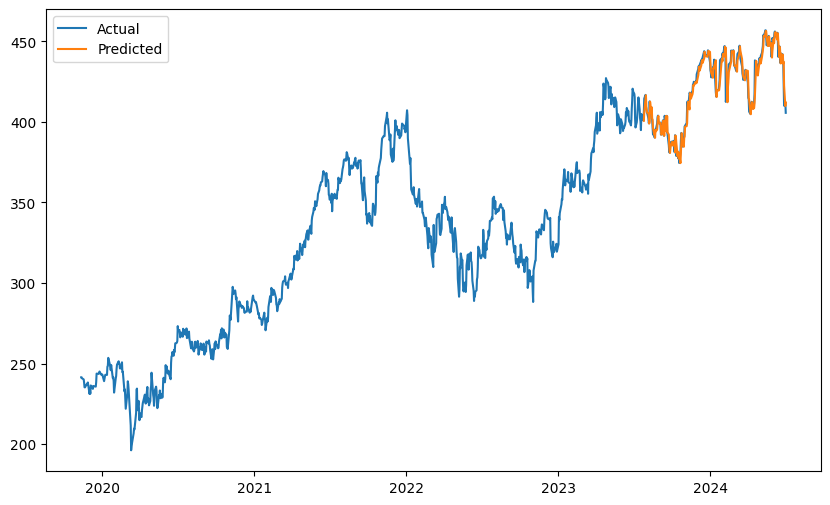

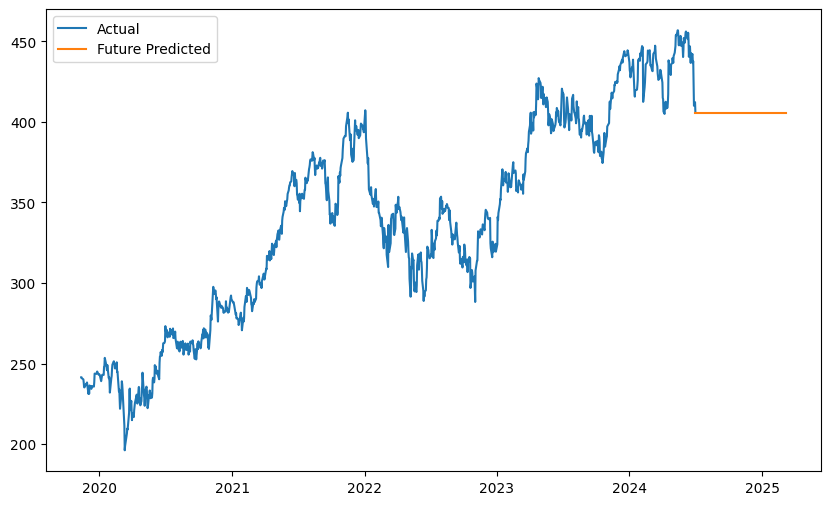

In [3]:
# Preprocessing data

# Convert to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce', utc = True)
currency_df['Date'] = pd.to_datetime(currency_df['Date'], utc = True)
indices_df['Date'] = pd.to_datetime(indices_df['Date'], utc = True)

# Remove invalid Date
stock_df = stock_df.dropna(subset=['Date'])
currency_df = currency_df.dropna(subset=['Date'])
indices_df = indices_df.dropna(subset=['Date'])

# Consider only date part
stock_df['Date'] = stock_df['Date'].dt.date
currency_df['Date'] = currency_df['Date'].dt.date
indices_df['Date'] = indices_df['Date'].dt.date

# Merge csv files
merged_df = pd.merge(stock_df, currency_df, on='Date', how='inner')
merged_df = pd.merge(merged_df, indices_df, on='Date', how='inner')

# Use only the relevant columns
merged_df = merged_df[['Date', 'Close_x', 'Close_y', 'Total_Sales_EUR_Million', 'EPS']]
merged_df.columns = ['Date', 'Close stock price', 'Close currency rate', 'Total sales', 'EPS']

# Ensure the 'Date' column is in datetime format and set as index
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df.set_index('Date', inplace=True)

# Create lag features
merged_df['Stock_Price_Lag1'] = merged_df['Close stock price'].shift(1)
merged_df['Currency_Rate_Lag1'] = merged_df['Close currency rate'].shift(1)

# Drop missing values
merged_df.dropna(inplace=True)

# Split data into features (X) and target (y)
X = merged_df[['Stock_Price_Lag1', 'Currency_Rate_Lag1']]
y = merged_df['Close stock price']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Squared Error and R^2 Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Create the prediction formula 
coefficients = model.coef_
intercept = model.intercept_
formula = f"Predicted Stock Price = {coefficients[0]:.4f} * Stock_Price_Lag1 + {coefficients[1]:.4f} * Currency_Rate_Lag1 + {intercept:.4f}"
print(formula)

# Plot results
plt.figure(figsize=(10,6))
plt.plot(merged_df.index, merged_df['Close stock price'], label='Actual')
plt.plot(X_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Predict the closing stock price for the next 6 months (assuming 6 months is approximately 180 days)
future_dates = pd.date_range(start=merged_df.index[-1], periods=180, freq='B')  # Use business days frequency
future_data = pd.DataFrame(index=future_dates)
future_data['Stock_Price_Lag1'] = merged_df['Close stock price'].iloc[-1]
future_data['Currency_Rate_Lag1'] = merged_df['Close currency rate'].iloc[-1]

future_predictions = model.predict(future_data)

# Plot future predictions
plt.figure(figsize=(10,6))
plt.plot(merged_df.index, merged_df['Close stock price'], label='Actual')
plt.plot(future_dates, future_predictions, label='Future Predicted')
plt.legend()
plt.show()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Preprocessing data

# Convert to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce', utc=True)
currency_df['Date'] = pd.to_datetime(currency_df['Date'], utc=True)
indices_df['Date'] = pd.to_datetime(indices_df['Date'], utc=True)

# Remove invalid Date
stock_df = stock_df.dropna(subset=['Date'])
currency_df = currency_df.dropna(subset=['Date'])
indices_df = indices_df.dropna(subset=['Date'])

# Consider only date part
stock_df['Date'] = stock_df['Date'].dt.date
currency_df['Date'] = currency_df['Date'].dt.date
indices_df['Date'] = indices_df['Date'].dt.date

# Merge csv files using outer join
merged_df = pd.merge(stock_df, currency_df, on='Date', how='outer')
merged_df = pd.merge(merged_df, indices_df, on='Date', how='outer')

# Use only the relevant columns
merged_df = merged_df[['Date', 'Close_x', 'Close_y', 'Total_Sales_EUR_Million', 'EPS']]
merged_df.columns = ['Date', 'Stock_Price', 'Currency_Rate', 'Total_Sales', 'EPS']

# Ensure the 'Date' column is in datetime format and set as index
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df.set_index('Date', inplace=True)

# Create lag features for the columns 'Stock_Price', 'Currency_Rate', 'EPS', 'Total_Sales'
for i in range(1, 31):  # For each lag from 1 to 30
    merged_df[f'Stock_Price_Lag{i}'] = merged_df['Stock_Price'].shift(i)
    merged_df[f'Currency_Rate_Lag{i}'] = merged_df['Currency_Rate'].shift(i)
    merged_df[f'Total_Sales_Lag{i}'] = merged_df['Total_Sales'].shift(i)
    merged_df[f'EPS_Lag{i}'] = merged_df['EPS'].shift(i)

# Drop rows with NaN values generated by the shifting (so the model doesn't use incomplete data)
merged_df = merged_df.dropna()

# Define the lag features (now only for the actual columns)
lag_features = [f'Stock_Price_Lag{lag}' for lag in range(1, 31)] + \
               [f'Currency_Rate_Lag{lag}' for lag in range(1, 31)] + \
               [f'Total_Sales_Lag{lag}' for lag in range(1, 31)] + \
               [f'EPS_Lag{lag}' for lag in range(1, 31)]

# Prepare the data for training
X = merged_df[lag_features]
y = merged_df['Stock_Price']  # Or whichever target you want to predict

# Check if there are any NaN values
if X.isnull().values.any() or y.isnull().values.any():
    raise ValueError("There are NaN values in the dataset.")

# Split data into train and test sets (you can choose to use all historical data for training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Linear Regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error and R^2 Score
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Plot results for test set predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

C:\Users\abcam\AppData\Local\Temp\ipykernel_7016\3456084626.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'Total_Sales_Lag{i}'] = merged_df['Total_Sales'].shift(i)
C:\Users\abcam\AppData\Local\Temp\ipykernel_7016\3456084626.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'EPS_Lag{i}'] = merged_df['EPS'].shift(i)
C:\Users\abcam\AppData\Local\Temp\ipykernel_7016\3456084626.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

# Result breakdown

**Mean Squared Error:** The relatively low MSE(about 29.1) compared to the range of mean close prices from 238.9 to 415.8 indicates that the model's predictions are quite close to the actual values.

**R-squared score:** R-squared approximately 0.94 reveals that about 94% of the variance in the stock prices is explained by the model. It can be said that this model has a strong predictive capability with high reliability.

**Formula:** The model has calculated the general formula for predicting the stock price based 

In [ ]:
# Preprocessing data

# Convert to datetime and consider the date part
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc = True).dt.date
currency_df['Date'] = pd.to_datetime(currency_df['Date'], utc = True).dt.date
indices_df['Date'] = pd.to_datetime(indices_df['Date'], utc = True).dt.date

# Consider only the relevant columns
# stock_df = stock_df[['Date', 'Close']]
stock_df.columns = ['Date', 'Close Stock Price']
# currency_df = currency_df[['Date', 'Close']]
currency_df.columns = ['Date', 'Close Currency Rate']
indices_df = indices_df[['Date', 'Total_Sales_EUR_Million', 'EPS']]

# Merge the dataframes on 'Date' column
merged_df = pd.merge(stock_df, currency_df, on = 'Date', how = 'outer')
merged_df = pd.merge(merged_df, indices_df, on = 'Date', how = 'outer')

# Handle missing values
cutoff_date = pd.to_datetime('2019-11-11').date()
merged_df = merged_df[merged_df['Date'] >= cutoff_date]
merged_df.interpolate(method='linear', inplace=True)
merged_df.to_csv('merged_data.csv', index=False)


          Date  Close Stock Price  Close Currency Rate  \
41  2019-11-11         240.710312             1.102244   
42  2019-11-12         241.446991             1.103546   
43  2019-11-13         241.446991             1.101237   
44  2019-11-14         240.802383             1.101322   
45  2019-11-15                NaN             1.102050   

    Total_Sales_EUR_Million    EPS  
41              7587.798913  3.565  
42              7580.689130  3.570  
43              7573.579348  3.575  
44              7566.469565  3.580  
45              7559.359783  3.585  
